In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_json ('news_dataset.json', lines=True)

In [4]:
df["label"] = np.where(df['topic']!= 'Football', 0, 1)

In [5]:
df.head()

,name,snippet,topic,label
0,Biden speech - live: President calls white sup...,Joe Biden is delivering his first major speech...,Other,0
1,Metro Nashville school board speaks out agains...,The resolution also lays down how the district...,Other,0
2,Amend <b>Corona</b> App To Show Beds With Oxyg...,The Delhi High Court on Wednesday issued a num...,Corona,0
3,<b>Chess</b>: Russia&#39;s Nepomniachtchi to c...,Russian chess grandmaster Ian Nepomniachtchi c...,Sports,0
4,"World <b>Athletics</b> Relays: who, what and w...",Major withdrawals have hit this weekend’s Worl...,Sports,0


Exploratory Data Analysis (EDA)

In [6]:
def visualize(attribute):
  groups = df.groupby(attribute)
  counts = groups.size()
  import matplotlib.pyplot as plt
  %matplotlib inline
  from matplotlib.pyplot import figure

  figure(figsize=(10, 6), dpi=80)
  counts.plot(kind='bar')
  plt.xlabel(attribute)
  plt.ylabel('Number of Comments')
  plt.title('Number of comments per '+attribute)

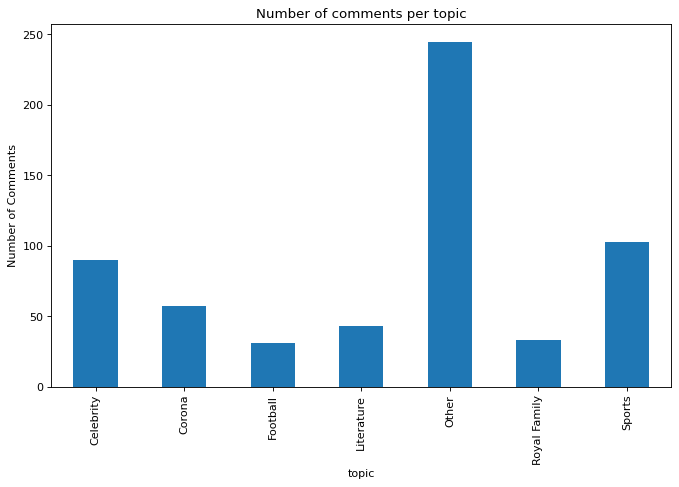

In [7]:
visualize('topic')

"Other" topic is the most frequent one. "football" is the least frquent one. -I see you're trying to please the CEO- 
This gives us an insight on the distributivity of the data and the topics available in the dataset

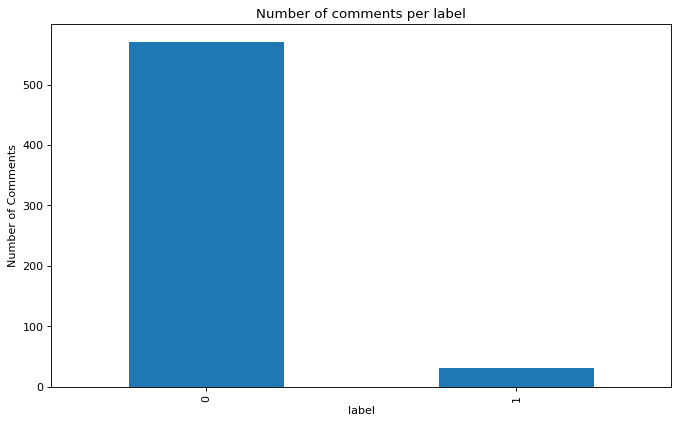

In [8]:
visualize('label')

It's clear now that the data is not well balanced and this may cause some problems with the model.

In [9]:
print("max snippet length" , df["snippet"].str.len().max())
print("min snippet length", df["snippet"].str.len().min())

max snippet length 435
min snippet length 14


In [10]:
import wordcloud

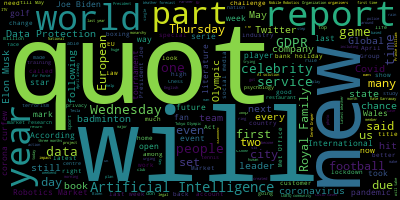

In [11]:
#most used words in the snippets
long_string = " ".join(df["snippet"])
_wordcloud = wordcloud.WordCloud()
_wordcloud.generate(long_string)
_wordcloud.to_image()

Though this doesn't provide much insight in this situation, we can still have some idea about the words used in the snippets

Preprocessing the data \n 


1.   Removing ponctuation: ponctuation does not change anything in the topic of the snippet.
2.   Transforming to lowercase: Just like any other data case, we would like to have our data normalized and in this case we do it by lowercasing the words. This way, there's no difference between "the" and "The". They are the same word.
3. Removing stop words: Stop words are very frequent, and have no impact on the meaning of the snippet. Their frequency can impact the model learning though. This is why we should remove them.
4. Stemming:  Stemming is used so that all the words with the same origin are understood and considered as the same word.



In [12]:
import re
# Remove punctuation
df['snippet'] = df['snippet'].map(lambda x: re.sub('[,\.!?]', '', x))
# Lowercase the words
df['snippet'] = df['snippet'].map(lambda x: x.lower())

In [13]:
# Removing stop words from comments
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['snippet'] = df['snippet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
#Stemming
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
df["snippet"] = df["snippet"].apply(lambda x: ' '.join(stemmer.stem(y) for y in x.split()))

In [15]:
df.head()

,name,snippet,topic,label
0,Biden speech - live: President calls white sup...,joe biden deliv first major speech congress fo...,Other,0
1,Metro Nashville school board speaks out agains...,resolut also lay district board advoc student ...,Other,0
2,Amend <b>Corona</b> App To Show Beds With Oxyg...,delhi high court wednesday issu number direct ...,Corona,0
3,<b>Chess</b>: Russia&#39;s Nepomniachtchi to c...,russian chess grandmast ian nepomniachtchi cli...,Sports,0
4,"World <b>Athletics</b> Relays: who, what and w...",major withdraw hit weekend world relay poland ...,Sports,0


# Modeling

I chose to go with a Deep Learning architecture which is LSTM in this case. We can also use Naive Bayes.

## **Naive Bayes**


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score


In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(df["snippet"],
                                                    df["label"],
                                                    train_size=0.8,
                                                    random_state=42,
                                                    )
x_train.shape

(481,)

In [22]:

# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Train the model using the training data
model.fit(x_train, y_train)
# Predict the categories of the test data
predicted_categories = model.predict(x_valid)

In [23]:
predicted_categories

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
y_valid.value_counts()

0    111
1     10
Name: label, dtype: int64

In [25]:
# plot the confusion matrix
confusion_matrix(y_valid, predicted_categories)

array([[111,   0],
       [ 10,   0]])

In [26]:
print("The accuracy is {}".format(accuracy_score(y_valid, predicted_categories)))

The accuracy is 0.9173553719008265


The accuracy may seem convinving but all the predicted values are 0. Which is not a reliable solution. This problem is probably due to the dataset being not balanced.

In [ ]:
y_train.value_counts()

0    513
1     28
Name: label, dtype: int64

## **Recurrent Neural Networks: LSTM**


In [27]:
(train_texts, valid_texts, train_labels, valid_labels) = train_test_split(list(df["snippet"]), list(df["label"]), test_size=0.1, random_state=42)

In [28]:
max_words = 10000
max_len = 350
epochs = 6
batch_size = 5

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

In [31]:
# Tokenize and pad data
sequences = tokenizer.texts_to_sequences(df["snippet"])
x = pad_sequences(sequences, maxlen=max_len)

In [32]:
x_train, x_valid, y_train, y_valid = train_test_split(x,
                                                    df["label"],
                                                    train_size=0.9,
                                                    random_state=42,
                                                    )
x_train.shape

(541, 350)

In [33]:
y_train.value_counts()

0    513
1     28
Name: label, dtype: int64

Data is not balanced, this is why we will be balancing it by oversampling the training dataset.

In [34]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(x_train, y_train)
y_res.value_counts()

1    513
0    513
Name: label, dtype: int64

In [35]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

In [44]:
model = Sequential()
model.add(Embedding(max_words, 12, input_length=max_len))
model.add(LSTM(6))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy')

In [45]:
checkpoint_callback_lstm = ModelCheckpoint('./results/lstm',
                                                   monitor='val_accuracy',
                                                   save_best_only=True,
                                                   verbose=1)

In [46]:
 history_lstm = model.fit((X_res),
                                 np.array(y_res),
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_data=(x_valid, np.array(y_valid)),
                                 callbacks=[checkpoint_callback_lstm])

Epoch 1/6
206/206 [==============================] - ETA: 0s - loss: 0.4193 - accuracy: 0.9133
Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to ./results/lstm


INFO:tensorflow:Assets written to: ./results/lstm/assets


INFO:tensorflow:Assets written to: ./results/lstm/assets


206/206 [==============================] - 18s 79ms/step - loss: 0.4193 - accuracy: 0.9133 - val_loss: 0.2032 - val_accuracy: 1.0000
Epoch 2/6
205/206 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 1.0000
Epoch 00002: val_accuracy did not improve from 1.00000
206/206 [==============================] - 10s 48ms/step - loss: 0.0959 - accuracy: 1.0000 - val_loss: 0.0913 - val_accuracy: 1.0000
Epoch 3/6
205/206 [============================>.] - ETA: 0s - loss: 0.0426 - accuracy: 1.0000
Epoch 00003: val_accuracy did not improve from 1.00000
206/206 [==============================] - 10s 48ms/step - loss: 0.0426 - accuracy: 1.0000 - val_loss: 0.0450 - val_accuracy: 1.0000
Epoch 4/6
205/206 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 1.0000
Epoch 00004: val_accuracy did not improve from 1.00000
206/206 [==============================] - 10s 48ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 5/6
206/206 

LSTM Inference

In [47]:
def get_prediction_lstm(input_text):
    text_sequences = tokenizer.texts_to_sequences([input_text])
    text_sequences = pad_sequences(text_sequences, maxlen=max_len)
    result = model.predict(text_sequences)
    return np.where(result > 0.5, "Dislike", "Like")[0][0]

In [48]:
get_prediction_lstm(df['snippet'][df['label']==1][12])

'Dislike'

In [49]:
get_prediction_lstm(df['snippet'][df['label']==0][601])

'Like'

In [50]:
input_text=valid_texts[20]

In [51]:
input_text= ' '.join([word for word in input_text.split() if word not in (stop)])
input_text= ' '.join(stemmer.stem(y) for y in input_text.split(' '))

In [52]:
print(input_text)

delhi high court wednesday issu number direct categori bed delhi corona mobil app set helplin number delay test shortag rtpcr test kit


In [53]:
print(get_prediction_lstm(input_text))

Like


In [54]:
valid_labels[20]

0

In [55]:
input_text="football player Leo Messi has one his first match after a long time of not scoring"

In [56]:
input_text= ' '.join([word for word in input_text.split() if word not in (stop)])
input_text= ' '.join(stemmer.stem(y) for y in input_text.split(' '))

In [57]:
print(get_prediction_lstm(input_text))

Like


In [58]:
input_text="A new COVID 19 variant has emerged. Corona is real. be safe"

In [59]:
input_text= ' '.join([word for word in input_text.split() if word not in (stop)])
input_text= ' '.join(stemmer.stem(y) for y in input_text.split(' '))

In [60]:
print(get_prediction_lstm(input_text))

Like
